# 내용 요약
- 모델 설계 복습
- 데이터 전처리 복습
- checkpoint 저장을 사용한 모델 저장 및 불러오기

# Import List

In [2]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import  datasets

import matplotlib.pyplot as plt
%matplotlib inline

# 하이퍼 파라미터 셋팅

In [46]:
numEpochs = 50
batchSize = 100

learningRate = 0.001

dropoutRate = 0.5

inputShape = (32, 32, 3)
numClasses = 10

# Build Model

![CNN](images/CNN.png)

In [47]:
inputs = layers.Input(inputShape)

net = layers.Conv2D(32, (3,3), padding = 'SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding = 'SAME')(net)
net = layers.MaxPooling2D(pool_size=(2,2))(net)
net = layers.Dropout(dropoutRate)(net)

net = layers.Conv2D(64, (3,3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3,3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2,2))(net)
net =  layers.Dropout(dropoutRate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropoutRate)(net)
net = layers.Dense(numClasses)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs = inputs, outputs = net, name = 'Basic_CNN')

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learningRate),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [49]:
model.summary()

Model: "Basic_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18

# 데이터 전처리

In [50]:
trainPaths = glob('dataset/cifar/train/*.png')
testPaths = glob('dataset/cifar/test/*.png')

In [51]:
len(trainPaths), len(testPaths)

(50000, 10000)

In [52]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

print(f'[get_class_name] output : {trainPaths[0]} -> {get_class_name(trainPaths[0])}')

[get_class_name] output : dataset/cifar/train/32270_deer.png -> deer


In [53]:
trainLabels = [get_class_name(path) for path in trainPaths]
classNames = np.unique(trainLabels)

print(f"trainLabels : {trainLabels[:3]} ...")
print(f"classNames : {classNames}")

trainLabels : ['deer', 'cat', 'deer'] ...
classNames : ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [54]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lblName = tf.strings.regex_replace(fname, '.png', '')

    onehot = tf.cast(lblName == classNames, tf.uint8)
    return tf.argmax(onehot)

In [55]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.

    label = get_label(path)
    return image, label

In [56]:
def image_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    return image, label

In [57]:
AUTOTUNE = tf.data.experimental.AUTOTUNE    

- AUTOTUNE은 tf.data에 런타임에 값을 동적으로 조정하도록 요청합니다.
- tf.data는 모든 조정 가능한 작업에서 올바른 CPU 예산을 찾습니다.
- AUTOTUNE은 버퍼 크기, CPU 예산 및 I / O 작업에 대한 병렬 처리 수준을 결정합니다

In [58]:
trainDataset = tf.data.Dataset.from_tensor_slices(trainPaths)
trainDataset = trainDataset.map(load_image_label)               # 모든 학습 데이터에 load_image_label 적용
trainDataset = trainDataset.map(image_preprocess)               # 모든 학습 데이터에 image_preprocess 적용
trainDataset = trainDataset.batch(batchSize)
trainDataset = trainDataset.shuffle(buffer_size=len(trainPaths))
trainDataset = trainDataset.repeat()

testDataset = tf.data.Dataset.from_tensor_slices(testPaths)
testDataset = testDataset.map(load_image_label)
testDataset = testDataset.batch(batchSize)
testDataset = testDataset.repeat()

# Check Point

모델을 저장할 떄 사용하는 콜백 함수이다.

```
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                             filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

```

In [59]:
savePath = 'checkPoints'

In [60]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    savePath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode = 'max'
)

# Training

In [61]:
stepsPerEpoch = len(trainPaths) // batchSize
validationSteps = len(testPaths) // batchSize

history = model.fit_generator(
    trainDataset,
    steps_per_epoch=stepsPerEpoch,
    validation_data=testDataset,
    validation_steps=validationSteps,
    epochs = numEpochs,
    callbacks=[checkpoint]
)

/Users/yoon-yeoungjin/miniforge3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-08-15 14:38:08.793817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2021-08-15 14:38:18.826942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1488 of 50000
2021-08-15 14:38:18.893437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


499/500 [============================>.] - ETA: 0s - loss: 1.7262 - accuracy: 0.3618

2021-08-15 14:38:35.315429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 28s 33ms/step - loss: 1.7255 - accuracy: 0.3621 - val_loss: 1.3615 - val_accuracy: 0.5037

Epoch 00001: val_accuracy improved from -inf to 0.50370, saving model to checkPoints


2021-08-15 14:38:36.484563: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: checkPoints/assets
Epoch 2/50
500/500 [==============================] - 15s 31ms/step - loss: 1.4125 - accuracy: 0.4831 - val_loss: 1.2400 - val_accuracy: 0.5494

Epoch 00002: val_accuracy improved from 0.50370 to 0.54940, saving model to checkPoints
INFO:tensorflow:Assets written to: checkPoints/assets
Epoch 3/50
500/500 [==============================] - 16s 31ms/step - loss: 1.2980 - accuracy: 0.5351 - val_loss: 1.1307 - val_accuracy: 0.5950

Epoch 00003: val_accuracy improved from 0.54940 to 0.59500, saving model to checkPoints
INFO:tensorflow:Assets written to: checkPoints/assets
Epoch 4/50
500/500 [==============================] - 15s 30ms/step - loss: 1.2096 - accuracy: 0.5642 - val_loss: 1.0561 - val_accuracy: 0.6157

Epoch 00004: val_accuracy improved from 0.59500 to 0.61570, saving model to checkPoints
INFO:tensorflow:Assets written to: checkPoints/assets
Epoch 5/50
500/500 [==============================] - 16s 33ms/step - loss: 1.1456 - 

# History 들여다보기

In [62]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [63]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 500}

In [64]:
newModel = history.model    # 모델을 담을 수 있다.

In [65]:
newModel.summary()

Model: "Basic_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18

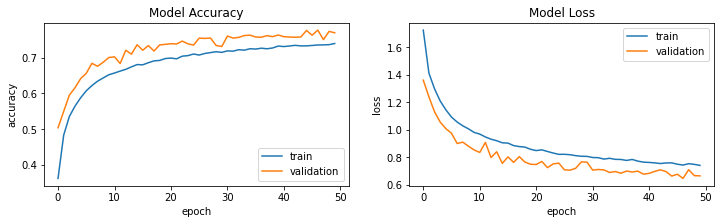

In [72]:
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
# plt.show()

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()

# Predict

## 이미지를 직접 load 해서 넣는 방법

In [75]:
path = testPaths[0]
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile)
image = image[tf.newaxis, ...]

print(f"[*] Test path : {path}")
print(f"[*] Test image shape : {image.shape}")

[*] Test path : dataset/cifar/test/2598_cat.png
[*] Test image shape : (1, 32, 32, 3)


In [82]:
pred = model.predict(image)
pred, np.argmax(pred), classNames[np.argmax(pred)]

(array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32), 5, 'dog')

## generator 해서 데이터를 가져오는 방법

In [83]:
testImage, testLabel = next(iter(testDataset))
testImage.shape, testLabel

(TensorShape([100, 32, 32, 3]),
 <tf.Tensor: shape=(100,), dtype=int64, numpy=
 array([3, 7, 4, 7, 1, 2, 3, 2, 1, 8, 0, 4, 1, 1, 5, 0, 5, 0, 9, 1, 4, 9,
        4, 9, 8, 6, 4, 1, 1, 3, 6, 4, 6, 9, 7, 6, 4, 9, 9, 7, 8, 7, 9, 8,
        2, 8, 1, 7, 2, 2, 3, 4, 5, 6, 0, 5, 9, 6, 1, 8, 3, 3, 5, 0, 0, 7,
        0, 7, 3, 2, 1, 5, 1, 6, 7, 9, 5, 7, 6, 5, 7, 9, 5, 4, 5, 6, 8, 3,
        2, 5, 6, 5, 3, 1, 8, 7, 6, 0, 6, 0])>)

In [86]:
pred = model.predict(testImage)
pred.shape

2021-08-15 15:06:25.688597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(100, 10)

In [89]:
for i in range(0, pred.shape[0]):
    index = np.argmax(pred[i])
    if index == testLabel[i].numpy():
        print("success")
    else:
        print("fail")

success
success
success
fail
fail
success
fail
fail
success
success
fail
success
success
success
success
fail
success
success
success
success
success
success
success
success
success
success
success
fail
success
fail
fail
success
success
success
fail
success
success
success
success
success
success
success
success
success
fail
success
success
success
fail
fail
success
success
success
success
success
success
success
success
success
success
success
fail
success
success
success
fail
success
success
fail
success
success
fail
fail
success
success
fail
fail
success
fail
success
success
success
fail
fail
success
success
success
fail
success
fail
success
success
fail
success
success
fail
success
success
success
success


## generator에 넣는 방법

In [90]:
pred = model.predict_generator(testDataset.take(1)) # 한개의 배치 만큼 가져옴

/Users/yoon-yeoungjin/miniforge3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
2021-08-15 15:09:08.324725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [91]:
pred.shape

(100, 10)

In [92]:
image, label = next(iter(testDataset))
eval = model.evaluate(image, label)

4/4 [==============================] - 0s 24ms/step - loss: 0.7539 - accuracy: 0.7300


2021-08-15 15:09:55.495742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [93]:
eval

[0.7539242506027222, 0.7299999594688416]

# Saving Model

In [94]:
savePath = 'checkPoints/myModel.h5'

In [95]:
model.save(savePath)

In [96]:
model.save(savePath, include_optimizer=True)    # model.compile 정보도 저장

In [97]:
# 모델 불러오기
model = tf.keras.models.load_model(savePath)

# Save model - 2

In [115]:
model.save_weights('checkPoints/myModelWeight.h5')

In [117]:
model.load_weights('checkPoints/myModelWeight.h5')  # json 형식은 읽을 수 없음

In [118]:
with open('checkPoints/myModelWeight.h5', 'w') as f:        # json 형식으로도 저장 가능
    f.write(model.to_json())

In [119]:
from tensorflow.keras.models import model_from_json

In [120]:
with open('checkPoints/myModelWeight.h5', 'r') as f:
    model = model_from_json(f.read())

# H5 모델 들여다보기

In [121]:
import h5py

In [122]:
modelFile = h5py.File(savePath)

In [123]:
modelFile.keys()

<KeysViewHDF5 ['model_weights', 'optimizer_weights']>

In [124]:
modelFile['model_weights'].keys()

<KeysViewHDF5 ['activation_14', 'activation_15', 'activation_16', 'activation_17', 'activation_18', 'conv2d_12', 'conv2d_13', 'conv2d_14', 'conv2d_15', 'dense_5', 'dense_6', 'dropout_10', 'dropout_11', 'dropout_9', 'flatten_3', 'input_4', 'max_pooling2d_6', 'max_pooling2d_7']>

In [127]:
modelFile['model_weights']['conv2d_12']['conv2d_12'].keys()

<KeysViewHDF5 ['bias:0', 'kernel:0']>

In [128]:
modelFile['model_weights']['conv2d_12']['conv2d_12']['kernel:0']

<HDF5 dataset "kernel:0": shape (3, 3, 3, 32), type "<f4">

In [129]:
weight = np.array(modelFile['model_weights']['conv2d_12']['conv2d_12']['kernel:0'])
weight.shape

(3, 3, 3, 32)